In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.backend import expand_dims
from tensorflow import keras, multiply, concat
from keras import layers, Input, Model, Sequential
import matplotlib.pyplot as plt
from tensorflow import keras

from keras.layers import LSTM, Dense, BatchNormalization
import sklearn.metrics
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Permute, Lambda
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.layers import ConvLSTM2D, ConvLSTM1D
import tensorflow_wavelets.Layers.DWT as DWT
import tensorflow_wavelets.Layers.DTCWT as DTCWT
import tensorflow_wavelets.Layers.DMWT as DMWT
import pywt
from tensorflow.python.keras.layers import Conv1D, GlobalAveragePooling2D

/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


We will be the e_price column displayed in the table below

In [2]:
dfe = pd.read_csv("elec_14_22.csv",parse_dates = True, delimiter=',', header=0)
dfe['date'] = pd.to_datetime(dfe['date'], format='%Y-%m-%d')
dfe.index = dfe["date"]
del dfe['date']
dfe.head()

,code,e_price,p2,p3,p4,rand,code2
date,,,,,,,
2014-12-05,N4F15,47.20,47.20,47.20,47.20,10,385
2014-12-08,N4F15,46.56,46.56,46.51,46.56,20,525
2014-12-09,N4F15,46.64,46.64,46.64,46.64,0,485
2014-12-10,N4F15,46.53,46.53,46.53,46.53,0,485
2014-12-11,N4F15,46.05,46.05,45.98,45.98,10,475


The Dickey-Fuller test is defined below

In [158]:
def Dickey_Fuller_Test(df, target_name):
    """
    Perform Dickey-Fuller test on the input time series to check if it's stationary
    :df: a time series as a pandas dataframe
    :target_name: the column name of the column in the series which we are checking
    """
    print('Results of Dickey-Fuller Test for column ',target_name)
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    for key,value in dftest[4].items(): #print the critical values
        if key == '5%':
            dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05: #if the p-value is less than 0.05 we reject the null hypothesis
        print("Conclusion:")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:")
        print("Fail to reject the null hypothesis")
        print("series is non-stationary")

In [5]:
Dickey_Fuller_Test(dfe['e_price'], 'e_price')

Results of Dickey-Fuller Test for column  e_price
Test Statistic        -1.994168
p-value                0.289136
Critical Value (5%)   -2.863067
dtype: float64
Conclusion:
Fail to reject the null hypothesis
series is non-stationary


In [6]:
diff_data = dfe['e_price'].diff().dropna()
Dickey_Fuller_Test(diff_data, 'e_price')

Results of Dickey-Fuller Test for column  e_price
Test Statistic        -1.022676e+01
p-value                5.152786e-18
Critical Value (5%)   -2.863067e+00
dtype: float64
Conclusion:
Reject the null hypothesis
Data is stationary


Electricity futures price data plotted below

Text(0, 0.5, 'Electricity price £/MWh')

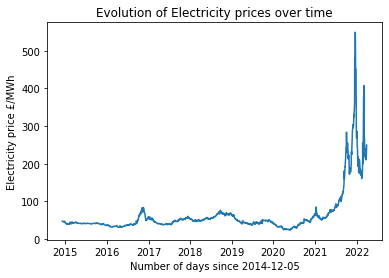

In [63]:
plt.plot(dfe['e_price'])
plt.title("Evolution of Electricity prices over time")
plt.xlabel("Number of days since 2014-12-05")
plt.ylabel("Electricity price £/MWh")

Text(0, 0.5, 'Electricity price (log (£/MWh))')

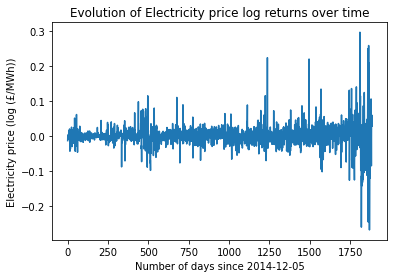

In [64]:
plt.plot(np.log(dfe['e_price']).diff(1).values)
plt.title("Evolution of Electricity price log returns over time")
plt.xlabel("Number of days since 2014-12-05")
plt.ylabel("Electricity price (log (£/MWh))")

In [4]:
trainset_size = 1737
testset_size = len(dfe['e_price']) - trainset_size
print("Size of training set will be set to just before the price spike area of dataset: ",trainset_size)

Size of training set will be set to just before the price spike area of dataset:  1737


In [69]:
testset_size

150

The data is split into data to be used for training and data to be used for testing

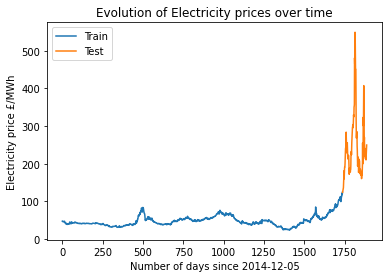

In [70]:
vals = dfe['e_price'].values

plt.plot(vals[:trainset_size], label="Train")
plt.plot(np.arange(trainset_size,len(dfe['e_price']),1),vals[trainset_size:], label="Test")
plt.title("Evolution of Electricity prices over time")
plt.xlabel("Number of days since 2014-12-05")
plt.ylabel("Electricity price £/MWh")
plt.legend()

Get PACF of differenced electricity data

Text(0, 0.5, 'Change in Electricity Prices £/MWh')

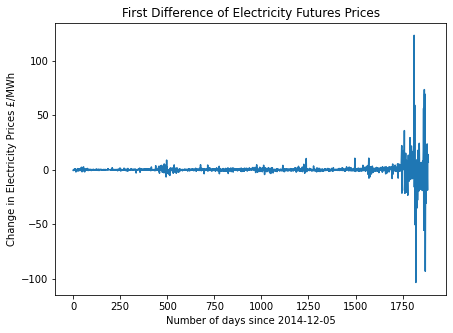

In [72]:
fig, axes = plt.subplots(1, 1, sharex=True)
fig.set_figwidth(7)
fig.set_figheight(5)
plt.plot(dfe['e_price'].diff().values)
plt.title("First Difference of Electricity Futures Prices")
plt.xlabel("Number of days since 2014-12-05")
plt.ylabel("Change in Electricity Prices £/MWh")

/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


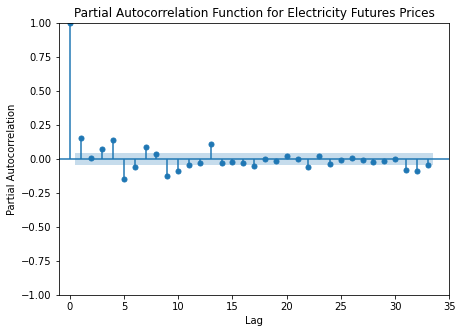

In [73]:
fig, axes = plt.subplots(1, 1, sharex=True)
fig.set_figwidth(7)
fig.set_figheight(5)

# axes[0].plot(dfe['e_price'].diff().values); axes[0].set_title('1st Differencing')
axes.set(ylim=(0,5))
axes.set(xlim=(-1,35))
plot_pacf(dfe['e_price'].diff().dropna().values, ax=axes)
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.title("Partial Autocorrelation Function for Electricity Futures Prices")
plt.show()

Get ACF of differenced electricity data

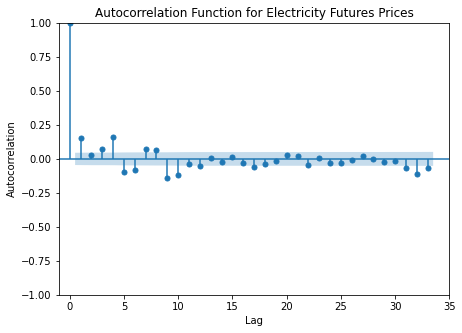

In [75]:
fig, axes = plt.subplots(1, 1, sharex=True)
fig.set_figwidth(7)
fig.set_figheight(5)

# axes[0].plot(dfe['e_price'].diff().values); axes[0].set_title('1st Differencing')
axes.set(ylim=(0,5))
axes.set(xlim=(-1,35))
plot_acf(dfe['e_price'].diff().dropna().values, ax=axes)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function for Electricity Futures Prices")
plt.show()

In [5]:
def calc_metrics(forecast,real=dfe['e_price'][trainset_size:].values):
    """
    Function calculates the metrics used in the analysis of the forecast of the models
    :param forecast: Forecast of the model
    :param real: Expected prices
    :return: tuple of length 4 of R-squared score, RMSE, MAE, MAPE
    """
    r2 = sklearn.metrics.r2_score(real, forecast)
    print("R-squared score is ", r2)
    rmse = sklearn.metrics.mean_squared_error(real, forecast,squared=False)
    print("RMSE is ", rmse)
    mae = sklearn.metrics.mean_absolute_error(real,forecast)
    mape = sklearn.metrics.mean_absolute_percentage_error(real, forecast)
    print("MAPE score is ", mape)
    return r2, rmse, mae, mape

Now the ARIMA(1,1,1) model is fitted and its prediction plotted

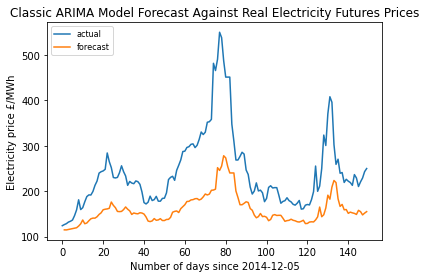

151


ValueError: Found input variables with inconsistent numbers of samples: [150, 151]

In [24]:
from statsmodels.tsa.arima.model import ARIMA
train = dfe['e_price'].values[:trainset_size]
test = dfe['e_price'].values[trainset_size:]

# 1,1,2 ARIMA Model
model = ARIMA(dfe['e_price'].values, order=(1,1,1))
fitted = model.fit()
#fc, se, conf = fitted.forecast(517-450, alpha=0.05)  # 95% conf
# Plot
pred_diff = dfe['e_price'][trainset_size-1:-1] - fitted.params[0] * dfe['e_price'][trainset_size-2:-2] -fitted.params[2]

fc = fitted.params[0] * dfe['e_price'][trainset_size-1:-1] + fitted.params[2] + fitted.params[1] * pred_diff

#plt.figure(figsize=(12,5), dpi=100)
plt.plot(test, label='actual')
plt.plot(fc.values, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series,
#                  color='k', alpha=.15)
plt.title('Classic ARIMA Model Forecast Against Real Electricity Futures Prices')
plt.xlabel("Number of days since 2014-12-05")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()
print(len(fc))
calc_metrics(fc)

In [ ]:
# from statsmodels.tsa.arima.model import ARIMA
# train = dfe['e_price'].values[:trainset_size]
# test = dfe['e_price'].values[trainset_size:]
#
# # 1,1,2 ARIMA Model
# model = ARIMA(dfe['e_price'].values, order=(1,1,1))
# fitted = model.fit()
# #fc, se, conf = fitted.forecast(517-450, alpha=0.05)  # 95% conf
# fc = fitted.forecast(testset_size, alpha=0.05)
# # Make as pandas series
# indices = np.arange(trainset_size,len(dfe['e_price']),1)
# fc_series = pd.Series(fc, index=indices)
# # lower_series = pd.Series(conf[:, 0], index=test.index)
# # upper_series = pd.Series(conf[:, 1], index=test.index)
# test_series = pd.Series(test, index = indices)
# # Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train, label='training')
# plt.plot(test_series, label='actual')
# plt.plot(fc_series, label='forecast')
# # plt.fill_between(lower_series.index, lower_series, upper_series,
# #                  color='k', alpha=.15)
# plt.title('Classic ARIMA Model Forecast Against Real Electricity Futures Prices')
# plt.xlabel("Number of days since 2014-12-05")
# plt.ylabel("Electricity price £/MWh")
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

In [25]:
def arima_preds(data,train_length,forecast_length,pred_length=5, order=(1,1,1)):
    """
    :param pred_length: The number of predictions to form
    :param order: the order of ARIMA model
    :param data: data used for model fitting
    :param train_length: number of data points used for fitting the model
    :param forecast_length: the number of data point to forecast
    :return: numpy array of forecasted data points with shape (forecast_length, pred_length)
    """
    forecast = np.zeros((forecast_length,pred_length))
    for i in range(forecast_length):
        model = ARIMA(data[i:train_length+i], order=order)
        fitted = model.fit()
        fc = fitted.forecast(pred_length, alpha=0.05)
        forecast[i, :] = fc[:]
    return forecast

In [26]:
window_sizes = np.arange(3,5,1)
window_sizes2 = np.arange(5,105,5)
forecasts = []
scores = []
for i in window_sizes:
    forecast = arima_preds(dfe['e_price'].values[trainset_size-i:],i,testset_size)
    forecasts.append(forecast)
    scores.append(calc_metrics(forecast[:,0].ravel()))
for i in window_sizes2:
    forecast = arima_preds(dfe['e_price'].values[trainset_size-i:],i,testset_size)
    forecasts.append(forecast)
    scores.append(calc_metrics(forecast[:,0].ravel()))

/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting para

R-squared score is  0.8778619362895504
RMSE is  28.894347584470008
MAPE score is  0.07298031075437761


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting para

R-squared score is  0.8706622000409635
RMSE is  29.7337792029745
MAPE score is  0.07159452033006748


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/y

R-squared score is  0.882917284496028
RMSE is  28.290053626890476
MAPE score is  0.069505017024963


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/sit

R-squared score is  0.8938702532137623
RMSE is  26.934315406392724
MAPE score is  0.06644325754392627


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/

R-squared score is  0.887928987335627
RMSE is  27.677956699630595
MAPE score is  0.06487185715757596


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.9014502408246382
RMSE is  25.954649065795568
MAPE score is  0.06184237380652329


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting 

R-squared score is  0.9047159995905824
RMSE is  25.520981259742875
MAPE score is  0.060636262891875736


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

R-squared score is  0.9034423431355182
RMSE is  25.690983879812347
MAPE score is  0.060896140348366073


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmo

R-squared score is  0.9041960212550025
RMSE is  25.59052232632246
MAPE score is  0.060443706509702794


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/y

R-squared score is  0.9052210453457399
RMSE is  25.453255365271254
MAPE score is  0.06094360001732018


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/pytho

R-squared score is  0.9036999042424536
RMSE is  25.656696507082536
MAPE score is  0.060992878838930516


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.9051303031897131
RMSE is  25.465437028991747
MAPE score is  0.061057574688589376


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'

R-squared score is  0.9068209464441553
RMSE is  25.237511213238832
MAPE score is  0.06038366745407313


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/

R-squared score is  0.9085761495551865
RMSE is  24.998683124518507
MAPE score is  0.059887640809389554


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.9111970443323598
RMSE is  24.637752483311232
MAPE score is  0.05985399575054232


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yash/DeepLearning/

R-squared score is  0.9100496395572173
RMSE is  24.796411301766167
MAPE score is  0.059810066813720524


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.9132723452700389
RMSE is  24.348161777630995
MAPE score is  0.059367223853309455


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.911196523544541
RMSE is  24.63782472765528
MAPE score is  0.05974878796293531


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.911209686762977
RMSE is  24.635998644372094
MAPE score is  0.0596742730984415


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.9111639156083089
RMSE is  24.64234771996215
MAPE score is  0.05984675322823391


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.9103968572999719
RMSE is  24.74850666508974
MAPE score is  0.059831140751806115


/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameter

R-squared score is  0.9113560316281974
RMSE is  24.61568765217432
MAPE score is  0.05977305744700491


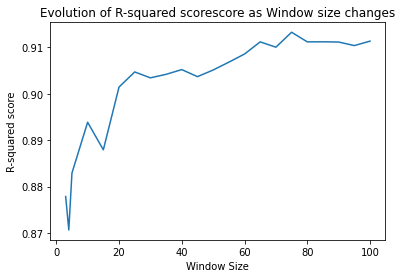

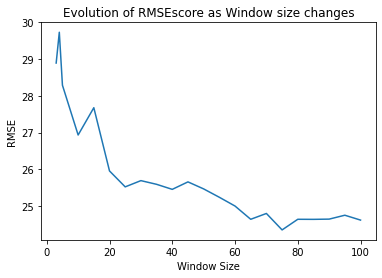

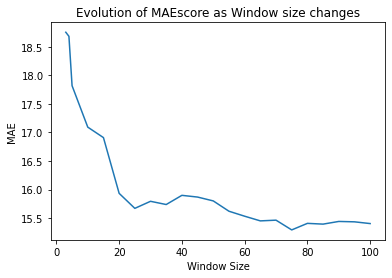

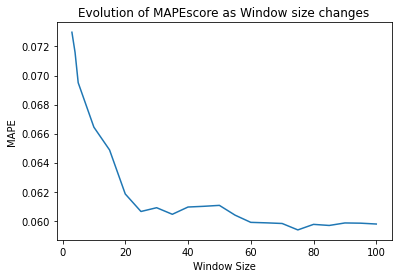

In [31]:
ylabel = ["R-squared score","RMSE","MAE","MAPE"]
for i in range(4):
    plt.plot(np.concatenate((window_sizes, window_sizes2), axis=0),np.array(scores)[:,i])
    plt.xlabel("Window Size")
    plt.ylabel(ylabel[i])
    plt.title("Evolution of " + ylabel[i] +"score as Window size changes")
    plt.show()

In [34]:
print("Highest R-squared value is "+ str(np.max(np.array(scores)[:,0])))

Highest R-squared value is 0.9132723452700389


In [139]:
scores[16]

0.5555457861405637

In [147]:
forecasts[16]

array([[ 45.42214885,  45.50851887,  45.56959009,  45.61277283,
         45.64330684],
       [ 44.46814216,  44.59098447,  44.68073135,  44.74629917,
         44.7942021 ],
       [ 43.67985098,  43.80960074,  43.90320603,  43.97073563,
         44.01945347],
       ...,
       [164.447507  , 164.45632166, 164.45556358, 164.45562877,
        164.45562317],
       [195.24319162, 195.07869312, 195.09097519, 195.09005817,
        195.09012663],
       [232.72637044, 232.56439309, 232.57247493, 232.57207169,
        232.57209181]])

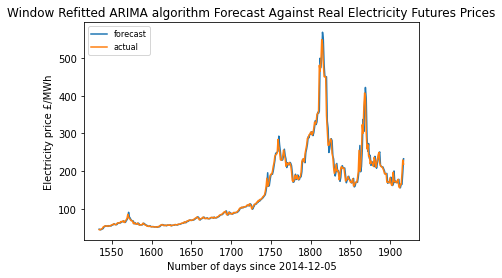

In [155]:

fc_series = pd.Series(forecasts[16][:,0], index=indices)
plt.plot(fc_series, label='forecast')
plt.plot(test_series, label='actual')

plt.title('Window Refitted ARIMA algorithm Forecast Against Real Electricity Futures Prices')
plt.xlabel("Number of days since 2014-12-05")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [100]:
def undiff(data, start_val):
    """
    :param data: numpy array to apply inverse of pandas diff function
    :param start_val: start value of the sequence
    :return: numpy array with undiff values
    """
    data[0] = start_val #first value of data array is NaN
    return np.cumsum(data)
#Test to see if undiff works
udf = undiff(dfe['e_price'].diff(),dfe['e_price'].iloc[0])
#if sum of differences is 0 then undiff works properly
print("Sum of differences between real and undiff values is ", np.sum(udf - dfe['e_price']))

Sum of differences between real and undiff values is  0.0


LSTM BaseLine model

In [160]:
type(dfe)

pandas.core.frame.DataFrame

Normalise data for neural network training

In [4]:
#mod data
#dfe2 = pd.read_csv("elect_19_22.csv",parse_dates = True, delimiter=',', header=0)


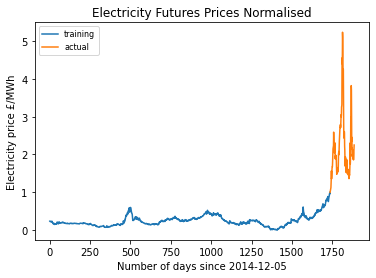

In [6]:
#dat = dfe2
dat=dfe
train_max_val = np.max(dat['e_price'].iloc[:trainset_size])
train_min_val = np.min(dat['e_price'].iloc[:trainset_size])
max_min_diff = train_max_val - train_min_val
elecs_norm = pd.DataFrame(dat['e_price']).apply(lambda x:(x-train_min_val)/max_min_diff)
#plot
train = elecs_norm.values[:trainset_size]
test = elecs_norm.values[trainset_size:]
indices = np.arange(trainset_size,len(dat['e_price']),1)
test_series = pd.Series(test.ravel(), index = indices)
plt.plot(train, label='training')
plt.plot(test_series, label='actual')

plt.title('Electricity Futures Prices Normalised')
plt.xlabel("Number of days since 2014-12-05")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [8]:
def make_single_lstm(units, observation_size, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(observation_size, 1)))
    model.add(tf.keras.layers.Dropout(dropout, noise_shape=None, seed=None))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mape', 'mae'])
    return model

Perform grid search for best LSTM configuration

In [15]:
window_size=10
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size=1,
    )
# --- Define training, validation and testing datasets
X_train = dataset.take(trainset_size-window_size)
X_test = dataset.skip(trainset_size-window_size).take(testset_size)

In [19]:



#Fit the model, forecast and test the results
units = [64,128,256]
dropouts = np.arange(0,1,0.1)
models = []
histories = []
forecasts = []
results = []
for unit in units:
    unit_histories = []
    unit_models = []
    unit_forecasts = []
    unit_results = []
    for dropout in dropouts:
        print("unit ", unit, " dropout ", dropout)
        model = make_single_lstm(unit,10,dropout=dropout)
        unit_histories.append(model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)]))
        forecast = model.predict(X_test)
        unit_forecasts.append(forecast)
        unit_models.append(model)
        unit_results.append(calc_metrics(forecast))
    models.append(unit_models)
    results.append(unit_results)
    histories.append(unit_histories)
    forecasts.append(unit_forecasts)
# model = make_single_lstm(64,10,dropout=0.2)
# model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
# forecast = model.predict(X_test)

unit  64  dropout  0.0
Epoch 1/15
1727/1727 [==============================] - 9s 4ms/step - loss: 9.0815e-04 - mape: 13257.6973 - mae: 0.0190 - val_loss: 0.3064 - val_mape: 15.0817 - val_mae: 0.3664
Epoch 2/15
1727/1727 [==============================] - 7s 4ms/step - loss: 0.0015 - mape: 14188.6357 - mae: 0.0242 - val_loss: 0.6521 - val_mape: 19.0234 - val_mae: 0.4610
Epoch 3/15
1727/1727 [==============================] - 7s 4ms/step - loss: 0.0020 - mape: 7827.7266 - mae: 0.0286 - val_loss: 0.3305 - val_mape: 16.9863 - val_mae: 0.4175
Epoch 4/15
1727/1727 [==============================] - 7s 4ms/step - loss: 0.0018 - mape: 17699.6270 - mae: 0.0259 - val_loss: 0.2845 - val_mape: 16.2341 - val_mae: 0.3938
R-squared score is  0.5811129913772686
MSE is  0.2844526747030072
MAPE score is  0.16234149096253206
unit  64  dropout  0.1
Epoch 1/15
1727/1727 [==============================] - 9s 4ms/step - loss: 0.0013 - mape: 13687.7461 - mae: 0.0245 - val_loss: 0.4756 - val_mape: 18.6878 - v

In [9]:
def denorm(data):
    """
    Function used to perform the denormalise the data
    :param data: normalised data, array like
    :return: denormalised data, array like
    """
    output = data * max_min_diff
    output = output + train_min_val
    return output

In [83]:
%store forecasts

Stored 'forecasts' (list)


In [61]:
forecast_array = np.array(forecasts)
result_array = np.zeros((forecast_array.shape[0],forecast_array.shape[1],4))
for i in range(forecast_array.shape[0]):
    for j in range(forecast_array.shape[1]):
        result_array[i,j,:] = calc_metrics(denorm(forecast_array[i,j]), real=dfe['e_price'].values[trainset_size:])

R-squared score is  0.5811130290609672
MSE is  53.51010505378564
MAPE score is  0.14638221289226439
R-squared score is  0.36059271313463737
MSE is  66.11137169752695
MAPE score is  0.191243500518775
R-squared score is  0.24285272462679575
MSE is  71.94118040297506
MAPE score is  0.22202979193828185
R-squared score is  0.37769848862319877
MSE is  65.22105286351729
MAPE score is  0.2041199489950842
R-squared score is  -0.17241624988651538
MSE is  89.52169408407093
MAPE score is  0.29136602587650573
R-squared score is  0.7541376907269595
MSE is  40.995232677021704
MAPE score is  0.1097547354997666
R-squared score is  0.13123579386804718
MSE is  77.06165593890695
MAPE score is  0.25255717995056465
R-squared score is  0.44761090842311035
MSE is  61.44830734334771
MAPE score is  0.1880164155219432
R-squared score is  -0.8944370905544796
MSE is  113.79612442960578
MAPE score is  0.39771900689967227
R-squared score is  -0.44257022717105743
MSE is  99.30151166335287
MAPE score is  0.32325643389

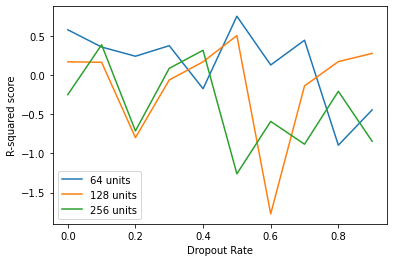

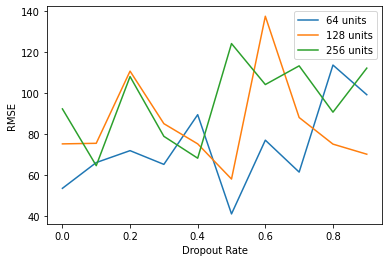

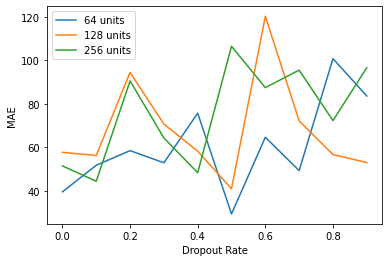

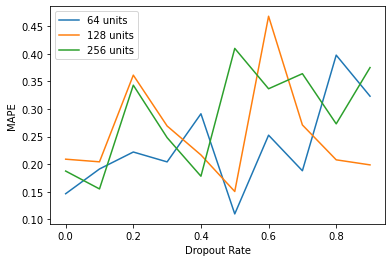

In [59]:
ylabels = ["R-squared score", "RMSE", "MAE", "MAPE"]
for i in range(4):
    for j in range(3):
        plt.plot(dropouts, result_array[j,:,i],label=str(units[j])+' units')
    plt.legend()
    plt.xlabel("Dropout Rate")
    plt.ylabel(ylabels[i])
    plt.show()

In [63]:
print("Best model is LSTM with 64 units and dropout 0.5")
print("This model achieved the results")
for i in range(4):
    print(ylabels[i] + ": " + str(result_array[0,5,i]))

Best model is LSTM with 64 units and dropout 0.5
This model achieved the results
R-squared score: 0.7541376907269595
RMSE: 40.995232677021704
MAE: 29.36161938069661
MAPE: 0.1097547354997666


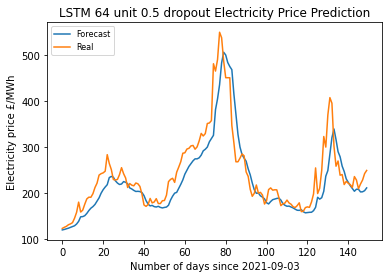

In [74]:
plt.plot(denorm(np.array(forecasts)[0,5,:]), label='Forecast')
plt.plot(dfe['e_price'][trainset_size:].values, label='Real')
plt.title('LSTM 64 unit 0.5 dropout Electricity Price Prediction')
plt.xlabel("Number of days since 2021-09-03")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()

CNN-LSTM

In [89]:
window_size=10
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size=1,
    )
# --- Define training, validation and testing datasets
X_train = dataset.take(trainset_size-window_size)
X_test = dataset.skip(trainset_size-window_size).take(testset_size)

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10, 1)]           0         
                                                                 
 conv3 (Conv1D)              (None, 8, 16)             64        
                                                                 
 lstm_34 (LSTM)              (None, 64)                20736     
                                                                 
 tf.identity_14 (TFOpLambda)  (None, 64)               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1727/1727 [==============================] 

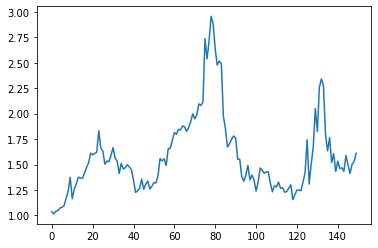

In [103]:
from keras.activations import selu
import convlstm
from importlib import reload
reload(convlstm)
model = convlstm.cnnlstm_model(sequence_length=window_size,activation=selu)
# model = Sequential([
#     Convolution1D(filters=filter_length, kernel_size=filter_length, activation=activation, padding='valid',
#                       kernel_initializer=init, input_shape=(sequence_length, features), name='conv1'),
#     AlphaDropout(0.2),
#     Convolution1D(filters=filter_length, kernel_size=filter_length, activation=activation, padding='valid',
#                       kernel_initializer=init, input_shape=(sequence_length, features), name='conv1')(x)
# ])
model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False)#, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
pred = model.predict(X_test)
plt.plot(pred)

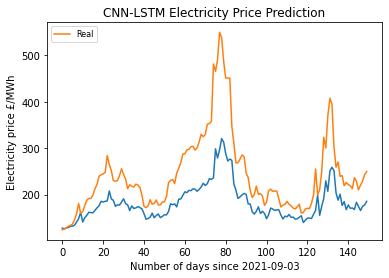

R-squared score is  0.14462143948650286
MSE is  76.46568049944085
MAPE score is  0.21925074079916398


(0.14462143948650286,
 76.46568049944085,
 60.038032706705735,
 0.21925074079916398)

In [104]:
plt.plot(denorm(pred))
plt.plot(dfe['e_price'][trainset_size:].values, label='Real')
plt.title('CNN-LSTM Electricity Price Prediction')
plt.xlabel("Number of days since 2021-09-03")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()
calc_metrics(denorm(pred), real=dfe['e_price'][trainset_size:].values)

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10, 1)]           0         
                                                                 
 conv3 (Conv1D)              (None, 8, 16)             64        
                                                                 
 max_pooling1d_36 (MaxPoolin  (None, 4, 16)            0         
 g1D)                                                            
                                                                 
 lstm1 (LSTM)                (None, 64)                20736     
                                                                 
 tf.identity_11 (TFOpLambda)  (None, 64)               0         
                                                                 
 dense_32 (Dense)            (None, 1)                 65        
                                                          

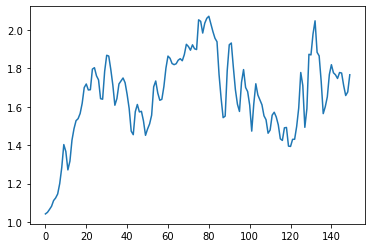

In [98]:
import tensorflow as tf
from keras import Input
from keras.layers import LSTM, AlphaDropout, Dense, Activation
from keras.layers.convolutional import Convolution1D, ZeroPadding1D
from tensorflow.python.keras.layers import Flatten, Dropout
inputs = Input(name='input', shape=(10, 1))
activation='relu'
filter_length=3
init = 'glorot_normal'
x = Convolution1D(filters=64, kernel_size=3, activation=activation, padding='valid',
                       kernel_initializer=init, input_shape=(window_size, 1), name='conv1')(inputs)
x = BatchNormalization()(x)
x = Convolution1D(filters=32, kernel_size=filter_length, activation=activation, padding='valid',
                  kernel_initializer=init, input_shape=(window_size, 1), name='conv2')(inputs)
x = BatchNormalization()(x)
x = Convolution1D(filters=16, kernel_size=filter_length, activation=activation, padding='valid',
                  kernel_initializer=init, input_shape=(window_size, 1), name='conv3')(inputs)
#x = BatchNormalization()(x)
x = tf.keras.layers.MaxPool1D(pool_size=2)(x)

x = LSTM(64, activation='relu',name='lstm1')(x)
x = Dropout(0.5)(x)
#x = Flatten()(tf.reshape(x, shape=(64,1)))
x = Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss='mse')
model.summary()
model.fit(X_train,epochs=30,validation_data=X_test, batch_size=1, verbose=1, shuffle=False)#, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
pred = model.predict(X_test)
plt.plot(pred)

In [105]:
def se_block(in_block, ch, ratio=16):
    x = GlobalAveragePooling2D()(in_block)
    x = Dense(ch//ratio, activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    return multiply()([in_block, x])

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10, 1)]           0         
                                                                 
 conv3 (Conv1D)              (None, 8, 16)             64        
                                                                 
 lstm_36 (LSTM)              (None, 64)                20736     
                                                                 
 tf.identity_16 (TFOpLambda)  (None, 64)               0         
                                                                 
 dense_37 (Dense)            (None, 1)                 65        
                                                                 
Total params: 20,865
Trainable params: 20,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1727/1727 [==============================] 

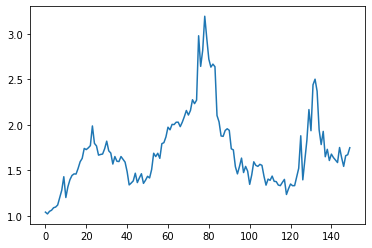

In [107]:
sequence_length = window_size
features = 1
inputs = Input(name='input', shape=(10, 1))
activation='selu'
filter_length=3
init = 'glorot_normal'
x = Convolution1D(filters=64, kernel_size=filter_length, activation=activation, padding='valid',
                       kernel_initializer=init, input_shape=(sequence_length, features), name='conv1')(inputs)
f = AlphaDropout(0.05)(x)

x = Convolution1D(filters=64, kernel_size=filter_length, activation=activation, padding='valid',
                  kernel_initializer=init, input_shape=(sequence_length, features), name='conv2')(inputs)
x = AlphaDropout(0.05)(x)

x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
x = Convolution1D(filters=32, kernel_size=filter_length, activation=activation, padding='valid',
                  kernel_initializer=init, input_shape=(sequence_length, features), name='conv3')(inputs)
x = AlphaDropout(0.05)(x)
x = Convolution1D(filters=32, kernel_size=filter_length, activation=activation, padding='valid',
                  kernel_initializer=init, input_shape=(sequence_length, features), name='conv3')(inputs)
x = AlphaDropout(0.05)(x)
x = Convolution1D(filters=16, kernel_size=filter_length, activation=activation, padding='valid',
                  kernel_initializer=init, input_shape=(sequence_length, features), name='conv3')(inputs)
x = LSTM(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss='mse')
model.summary()
model.fit(X_train,epochs=30,validation_data=X_test, batch_size=1, verbose=1, shuffle=False)#, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
pred = model.predict(X_test)
plt.plot(pred)

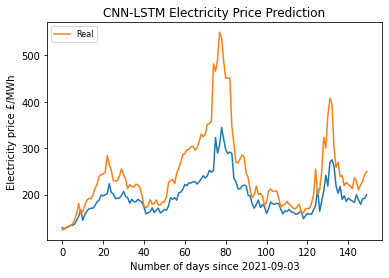

R-squared score is  0.3695803381861852
MSE is  65.6450906370448
MAPE score is  0.16669257188051576


(0.3695803381861852, 65.6450906370448, 47.508296612548826, 0.16669257188051576)

In [108]:
plt.plot(denorm(pred))
plt.plot(dfe['e_price'][trainset_size:].values, label='Real')
plt.title('CNN-LSTM Electricity Price Prediction')
plt.xlabel("Number of days since 2021-09-03")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()
calc_metrics(denorm(pred), real=dfe['e_price'][trainset_size:].values)

In [124]:
sequence_length = window_size
features = 1
inputs = Input(name='input', shape=(10, 1))
activation='selu'
filter_length=3
init = 'glorot_normal'
x = Convolution1D(filters=64, kernel_size=filter_length, activation=activation, padding='valid',
                       kernel_initializer=init, input_shape=(sequence_length, features), name='conv1')(inputs)
f = AlphaDropout(0.05)(x)

x = Convolution1D(filters=64, kernel_size=filter_length, activation=activation, padding='valid',
                  kernel_initializer=init, input_shape=(sequence_length, features), name='conv2')(inputs)
x = AlphaDropout(0.05)(x)

x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
x = Convolution1D(filters=32, kernel_size=filter_length, activation=activation, padding='valid',
                  kernel_initializer=init, input_shape=(sequence_length, features), name='conv3')(inputs)
x = AlphaDropout(0.05)(x)
x = Convolution1D(filters=32, kernel_size=filter_length, activation=activation, padding='valid',
                  kernel_initializer=init, input_shape=(sequence_length, features), name='conv3')(inputs)
x = AlphaDropout(0.05)(x)
x = Convolution1D(filters=16, kernel_size=filter_length, activation=activation, padding='valid',
                  kernel_initializer=init, input_shape=(sequence_length, features), name='conv3')(inputs)
x = tf.cast(tf.reshape(x, shape=(128,)),dtype=tf.int32)
l = LSTM(128, activation='relu')(inputs)
l = Dropout(0.9)(l)
l = tf.reshape(l, shape=(128,))
c = concat(l,x)
x = Dense(1)(c)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss='mse')
model.summary()
model.fit(X_train,epochs=30,validation_data=X_test, batch_size=1, verbose=1, shuffle=False)#, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
pred = model.predict(X_test)
plt.plot(pred)

ValueError: Exception encountered when calling layer "tf.concat_9" (type TFOpLambda).

Shape (128,) must have rank 0

Call arguments received by layer "tf.concat_9" (type TFOpLambda):
  • values=tf.Tensor(shape=(128,), dtype=float32)
  • axis=tf.Tensor(shape=(128,), dtype=int32)
  • name=concat

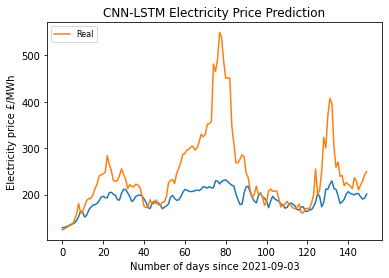

R-squared score is  -0.05161862221038338
MSE is  84.78450939948803
MAPE score is  0.1741614322886044


(-0.05161862221038338,
 84.78450939948803,
 53.61139933268228,
 0.1741614322886044)

In [99]:
plt.plot(denorm(pred))
plt.plot(dfe['e_price'][trainset_size:].values, label='Real')
plt.title('CNN-LSTM Electricity Price Prediction')
plt.xlabel("Number of days since 2021-09-03")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()
calc_metrics(denorm(pred), real=dfe['e_price'][trainset_size:].values)

In [96]:
pred.shape

(9600, 1)

In [ ]:
import ufcnn

Noisy data generation

In [21]:
def fn_addnoise(data,modify_length):
    # create 1D numpy data:
    npdata = data.values.copy().reshape(-1,1)
    # add uniform noise:
    npdata[:modify_length] = npdata[:modify_length] + np.random.uniform(size=modify_length).reshape(-1,1)
    # add laplace noise:
    #npdata[:modify_length] += np.random.laplace(loc=0.0, scale=1.0, size=modify_length).reshape(-1,1)
    return npdata

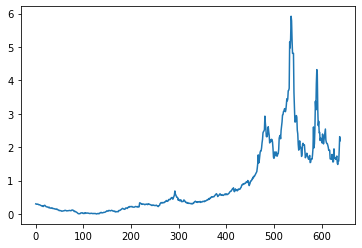

In [22]:
plt.plot(elecs_norm)

In [23]:
noisy_data = fn_addnoise(elecs_norm,trainset_size)

In [30]:
window_size=40
noisy_data = fn_addnoise(elecs_norm,trainset_size)
dataset = keras.utils.timeseries_dataset_from_array(
        data=noisy_data,
        targets=noisy_data[40:],
        sequence_length=40,
        batch_size=1,
    )
model = make_single_lstm(256,40)
# --- Define training, validation and testing datasets
X_train = dataset.take(trainset_size-window_size)
#X_val =dataset.skip(trainset_size-valset_size-window_size).take(valset_size)
X_test = dataset.skip(trainset_size-window_size).take(testset_size)
#Fit the model, forecast and test the results
hist = model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
forecast = model.predict(X_test)

Epoch 1/15
344/344 [==============================] - 8s 17ms/step - loss: 0.1142 - mape: 73.2325 - mae: 0.2884 - val_loss: 0.0295 - val_mape: 22.5976 - val_mae: 0.1411
Epoch 2/15
344/344 [==============================] - 6s 16ms/step - loss: 0.1046 - mape: 76.2138 - mae: 0.2782 - val_loss: 0.0147 - val_mape: 15.9144 - val_mae: 0.1032
Epoch 3/15
344/344 [==============================] - 6s 16ms/step - loss: 0.1010 - mape: 76.0795 - mae: 0.2755 - val_loss: 0.0174 - val_mape: 17.7036 - val_mae: 0.1142
Epoch 4/15
344/344 [==============================] - 6s 16ms/step - loss: 0.1009 - mape: 77.1890 - mae: 0.2759 - val_loss: 0.0166 - val_mape: 17.3113 - val_mae: 0.1127
Epoch 5/15
344/344 [==============================] - 6s 16ms/step - loss: 0.0981 - mape: 76.7602 - mae: 0.2721 - val_loss: 0.0173 - val_mape: 17.6589 - val_mae: 0.1153
Epoch 6/15
344/344 [==============================] - 6s 16ms/step - loss: 0.0962 - mape: 76.5787 - mae: 0.2695 - val_loss: 0.0174 - val_mape: 17.7413 - va

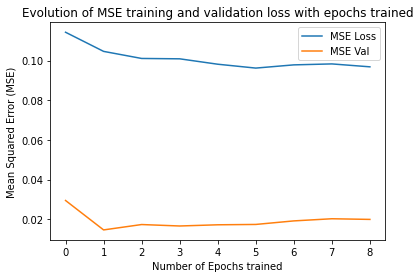

In [31]:
plt.plot(hist.history['loss'], label='MSE Loss')
plt.plot(hist.history['val_loss'], label='MSE Val')
plt.title("Evolution of MSE training and validation loss with epochs trained")
plt.xlabel("Number of Epochs trained")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()

In [32]:
calc_r2(pd.Series(forecast.ravel()),pd.Series(elecs_norm['e_price'].iloc[trainset_size-1:]),0)

-38.2883558083945

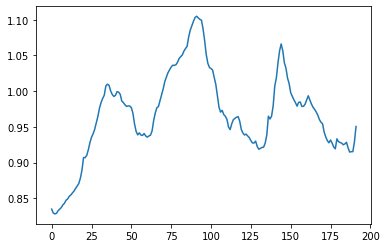

In [33]:
plt.plot(forecast)

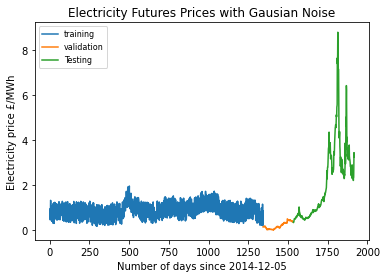

In [98]:
train = noisy_data[:trainset_size]
val = noisy_data[trainset_size:trainset_size]
test = noisy_data[trainset_size:]
indices = np.arange(trainset_size,len(dfe['e_price']),1)
val_indices = np.arange(trainset_size,trainset_size,1)
val_series = pd.Series(val.ravel(),index=val_indices)
test_series = pd.Series(test.ravel(), index = indices)
plt.plot(train, label='training')
plt.plot(val_series, label='validation')
plt.plot(test_series, label='Testing')

plt.title('Electricity Futures Prices with Gausian Noise')
plt.xlabel("Number of days since 2014-12-05")
plt.ylabel("Electricity price £/MWh")
plt.legend(loc='upper left', fontsize=8)
plt.show()

Training model with log prices

In [34]:
log_data = np.log(noisy_data+1)

In [36]:
window_size=40
noisy_data = fn_addnoise(elecs_norm,trainset_size-valset_size)
log_data = np.log(noisy_data+1)
dataset = keras.utils.timeseries_dataset_from_array(
        data=log_data,
        targets=log_data[40:],
        sequence_length=40,
        batch_size=1,
    )
model = make_single_lstm(256,40)
# --- Define training, validation and testing datasets
X_train = dataset.take(trainset_size-valset_size-window_size)
X_val =dataset.skip(trainset_size-valset_size-window_size)
X_test = dataset.skip(trainset_size-window_size).take(testset_size)
#Fit the model, forecast and test the results
hist = model.fit(X_train,epochs=15,validation_data=X_val, batch_size=1, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
forecast = np.exp(model.predict(X_test))-1

Epoch 1/15
344/344 [==============================] - 8s 19ms/step - loss: 0.0396 - mape: 44.0317 - mae: 0.1622 - val_loss: 0.0566 - val_mape: 17.9386 - val_mae: 0.1859
Epoch 2/15
344/344 [==============================] - 6s 18ms/step - loss: 0.0335 - mape: 43.7338 - mae: 0.1510 - val_loss: 0.1005 - val_mape: 23.2812 - val_mae: 0.2563
Epoch 3/15
344/344 [==============================] - 7s 20ms/step - loss: 0.0329 - mape: 43.9889 - mae: 0.1497 - val_loss: 0.1335 - val_mape: 26.4714 - val_mae: 0.2976
Epoch 4/15
344/344 [==============================] - 6s 17ms/step - loss: 0.0332 - mape: 44.5315 - mae: 0.1526 - val_loss: 0.1400 - val_mape: 27.2776 - val_mae: 0.3053
Epoch 5/15
344/344 [==============================] - 6s 17ms/step - loss: 0.0333 - mape: 44.5434 - mae: 0.1534 - val_loss: 0.1581 - val_mape: 28.8592 - val_mae: 0.3254
Epoch 6/15
344/344 [==============================] - 6s 17ms/step - loss: 0.0330 - mape: 44.7512 - mae: 0.1510 - val_loss: 0.1605 - val_mape: 29.2212 - va

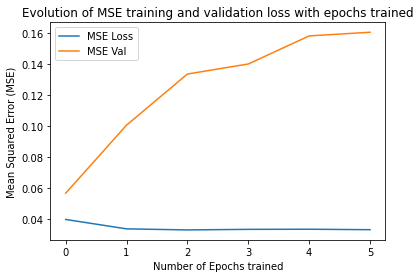

In [37]:
plt.plot(hist.history['loss'], label='MSE Loss')
plt.plot(hist.history['val_loss'], label='MSE Val')
plt.title("Evolution of MSE training and validation loss with epochs trained")
plt.xlabel("Number of Epochs trained")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()

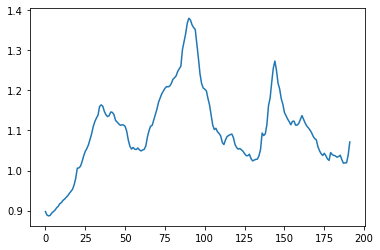

In [38]:
plt.plot(forecast)

In [40]:
calc_r2(pd.Series(forecast.ravel()),pd.Series(elecs_norm['e_price'].iloc[trainset_size-1:]),0)

-31.930881396643954

j

In [41]:
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Permute, Lambda
from keras.layers import TimeDistributed
import tensorflow as tf
from keras import Input
from keras.layers.convolutional import Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D, UpSampling1D, UpSampling2D, ZeroPadding1D
# from keras.layers.advanced_activations import ParametricSoftplus, SReLU
from keras.callbacks import ModelCheckpoint, Callback
def ufcnn_model_concat(sequence_length=5000,
                       features=1,
                       nb_filter=150,
                       filter_length=5,
                       output_dim=1,
                       optimizer='adagrad',
                       loss='mse',
                       regression = True,
                       class_mode=None,
                       activation="relu",
                       init="lecun_uniform",
                       wavelet = False):
    #model = tf.keras.Sequential()

    inputs = Input(name='input', shape=(10,1))
    #########################################################
    #x = ZeroPadding1D(2, name='input_padding') (inputs)# to avoid lookahead bias

    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='valid', kernel_initializer=init, input_shape=(sequence_length, features),name='conv1')(inputs)
    start = Activation(activation, name='relu1')(x)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv2')(start)
    start2 = Activation(activation, name='relu2')(x)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv3')(start2)
    x = Activation(activation, name='relu3')(x)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv4')(x)
    x = Activation(activation, name='relu4')(x)
    #########################################################
    x = tf.keras.layers.concatenate([start2, x], axis=-1)
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv5')(x)
    x = Activation(activation, name='relu5')(x)
    #########################################################

    #########################################################
    x = tf.keras.layers.concatenate([start, x], axis=-1)
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv6')(x)
    x = Activation(activation, name='relu6')(x)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv7')(x)
    x = LSTM(128)(x)#keras.layers.Flatten()(x)
    #x = Convolution1D(filters=1, kernel_size=1, padding='same', kernel_initializer=init, name='conv8')(x)

    x = Activation('relu', name='relu7')(x)

    # y = LSTM(128,return_sequences=True)(inputs)
    # y = LSTM(64)(y)
    # # y = Dense(1)(y)
    # x = tf.keras.layers.concatenate([x, y], axis=-1)
    x = Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=optimizer, loss='mse')

    return model

ARIMA based lstm

In [126]:
count = 1
z = tf.reshape(tf.convert_to_tensor([0.000001],dtype=tf.float64),shape=(1,1))#tf.convert_to_tensor(0.00001, dtype=tf.float64)
#tf.reshape(z,(1,1,1))
diffs = ([z,z,z,z,z,z,z,z,z,z])
def gen(inp):
    diffs.pop(0)
    diffs.append((tf.convert_to_tensor(inp)))
    return tf.reshape(tf.concat(tf.convert_to_tensor(diffs),axis=1),(1,10,1))

generator = iter(dataset)
window_size=10
noisy_data = fn_addnoise(elecs_norm,trainset_size-valset_size)
log_data = np.log(noisy_data+1)
batches=1
dataset = keras.utils.timeseries_dataset_from_array(
        data=log_data,
        targets=log_data[window_size:],
        sequence_length=window_size,
        batch_size=batches,
    )

# --- Define training, validation and testing datasets
X_train = dataset.take(trainset_size-window_size).shuffle(trainset_size-window_size, seed=12312)
#X_val =dataset.skip(trainset_size-valset_size-window_size).take(valset_size).shuffle(valset_size, seed=12312)
X_test = dataset.skip(trainset_size-window_size).take(testset_size).shuffle(testset_size, seed=12312)

input1 = Input(shape=(10,1))
#normed = rolling_norm(input1)
lstm1 = LSTM(128,activation='relu',return_sequences=True)(input1)
lstm2 = LSTM(128,activation='relu',return_sequences=False)(lstm1)
dense1 = Dense(1)(lstm2)
pred = tf.reshape(generator.__next__()[1] - tf.cast(dense1,tf.float64),(1,1))
#queue.enqueue(pred)
ma1 = LSTM(128,activation='relu',return_sequences=True)(gen(pred))
ma2 = LSTM(128,activation='relu',return_sequences=False)(ma1)
tens = tf.concat([lstm2,ma2],axis=-1)
output=Dense(1)(tens)
model = Model(inputs=input1,outputs=output,name='arima_mod')
model.compile(optimizer='adagrad',loss='mse')
model.summary()
hist_ar = model.fit(X_train,epochs=15,validation_data=X_val, batch_size=batches, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])

NameError: name 'fn_addnoise' is not defined

In [ ]:
count = 1
z = tf.reshape(tf.convert_to_tensor([0.000001],dtype=tf.float64),shape=(1,1))#tf.convert_to_tensor(0.00001, dtype=tf.float64)
#tf.reshape(z,(1,1,1))
diffs = ([z,z,z,z,z,z,z,z,z,z])
def gen(inp):
    diffs.pop(0)
    diffs.append((tf.convert_to_tensor(inp)))
    return tf.reshape(tf.concat(tf.convert_to_tensor(diffs),axis=1),(1,10,1))

generator = iter(dataset)
window_size=10
#noisy_data = fn_addnoise(elecs_norm,trainset_size-valset_size)
log_data = np.log(noisy_data+1)
batches=1
dataset = keras.utils.timeseries_dataset_from_array(
        data=log_data,
        targets=log_data[window_size:],
        sequence_length=window_size,
        batch_size=batches,
    )

# --- Define training, validation and testing datasets
X_train = dataset.take(trainset_size-window_size).shuffle(trainset_size-window_size, seed=12312)
#X_val =dataset.skip(trainset_size-valset_size-window_size).take(valset_size).shuffle(valset_size, seed=12312)
X_test = dataset.skip(trainset_size-window_size).take(testset_size).shuffle(testset_size, seed=12312)

input1 = Input(shape=(10,1))
#normed = rolling_norm(input1)
lstm1 = LSTM(128,activation='relu',return_sequences=True)(input1)
lstm2 = LSTM(128,activation='relu',return_sequences=False)(lstm1)
dense1 = Dense(1)(lstm2)
pred = tf.reshape(generator.__next__()[1] - tf.cast(dense1,tf.float64),(1,1))
#queue.enqueue(pred)
ma1 = LSTM(128,activation='relu',return_sequences=True)(gen(pred))
ma2 = LSTM(128,activation='relu',return_sequences=False)(ma1)
tens = tf.concat([lstm2,ma2],axis=-1)
output=Dense(1)(tens)
model = Model(inputs=input1,outputs=output,name='arima_mod')
model.compile(optimizer='adagrad',loss='mse')
model.summary()
hist_ar = model.fit(X_train,epochs=15,validation_data=X_val, batch_size=batches, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])

-43.80924926973538


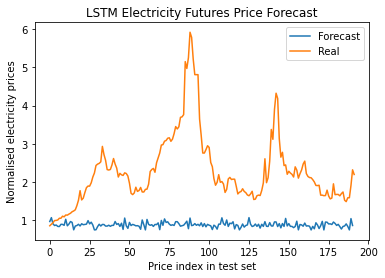

In [49]:
forecast_ar = np.exp(model.predict(X_test))-1
print(calc_r2(pd.Series(forecast_ar.ravel()[:-1]),pd.Series(elecs_norm['e_price'].iloc[trainset_size:]),0))
plt.plot(forecast_ar.ravel()[:-1], label='Forecast')
plt.plot(pd.Series(elecs_norm['e_price'].iloc[trainset_size:]).values, label='Real')
plt.xlabel("Price index in test set")
plt.ylabel("Normalised electricity prices")
plt.title("LSTM Electricity Futures Price Forecast")
plt.legend()
plt.show()

Wavelet LSTM

In [63]:
a,b,c,d,e,f = pywt.wavedec(dfe2['e_price'], 'db6', level=5)
abcd = (np.array([a,b,c,d,e,f]))
print(abcd)
dataset = keras.utils.timeseries_dataset_from_array(
        data=abcd,
        targets=abcd[window_size:],
        sequence_length=window_size,
        batch_size=1,)
model = keras.Sequential()
model.add(LSTM(128, activation='relu', input_shape=(10, 1),return_sequences=True))
model.add(LSTM(128, activation='relu',return_sequences=True))
model.add(LSTM(128, activation='relu'))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')
hist_wa = model.fit(X_train,epochs=15,validation_data=X_val, batch_size=batches, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
pred_wavelet = model.predict(X_test)
p = pred_wavelet
pp = [p[0][0]]
pp2 = [p[0][1]]
for i in range(1,len(p),2):
    pp.append(p[i][0])
    pp2.append(p[i][1])
rev = pywt.idwt(pp,pp2, 'db6')
plt.plot(rev)

(6,)


/var/folders/2x/r7stqt9j3ys7q29zxm50kcv40000gn/T/ipykernel_20334/3206590114.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  abcd = (np.array([a,b,c,d,e,f]).shape)


ValueError: `sampling_rate` must be lower than the length of the data. Received: sampling_rate=1, for data of length 1

-323878.1420324578


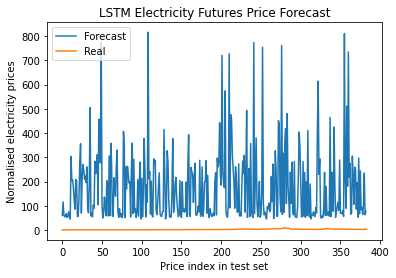

In [118]:
forecast_wa = np.exp(model.predict(X_test))-1
print(calc_r2(pd.Series(forecast_wa.ravel()[:-1]),pd.Series(elecs_norm['e_price'].iloc[trainset_size:]),0))
plt.plot(forecast_wa.ravel()[:-1], label='Forecast')
plt.plot(pd.Series(elecs_norm['e_price'].iloc[trainset_size:]).values, label='Real')
plt.xlabel("Price index in test set")
plt.ylabel("Normalised electricity prices")
plt.title("LSTM Electricity Futures Price Forecast")
plt.legend()
plt.show()

In [65]:
arr = []
for i in range(2, len(dfe2['e_price'])):
    a,b = pywt.wavedec(dfe2['e_price'].iloc[:i], 'db1', level=1)
    arr.append(np.array([a[-1],b[-1]]))

dataset = keras.utils.timeseries_dataset_from_array(
    data=arr[:-1],
    targets=arr[window_size:],
    sequence_length=window_size,
    batch_size=1,
)
model = keras.Sequential()
model.add(LSTM(128, activation='relu', input_shape=(10, 1),return_sequences=True))
model.add(LSTM(128, activation='relu',return_sequences=True))
model.add(LSTM(128, activation='relu'))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')
hist_wa = model.fit(X_train,epochs=15,validation_data=X_val, batch_size=batches, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])

Epoch 1/15
438/438 [==============================] - 9s 11ms/step - loss: 0.0425 - val_loss: 0.0185
Epoch 2/15
438/438 [==============================] - 4s 9ms/step - loss: 0.0330 - val_loss: 0.0100
Epoch 3/15
438/438 [==============================] - 4s 9ms/step - loss: 0.0335 - val_loss: 0.0093
Epoch 4/15
438/438 [==============================] - 4s 9ms/step - loss: 0.0306 - val_loss: 0.0186
Epoch 5/15
438/438 [==============================] - 4s 9ms/step - loss: 0.0318 - val_loss: 0.0175
Epoch 6/15
438/438 [==============================] - 4s 9ms/step - loss: 0.0312 - val_loss: 0.0066
Epoch 7/15
438/438 [==============================] - 4s 9ms/step - loss: 0.0317 - val_loss: 0.0097


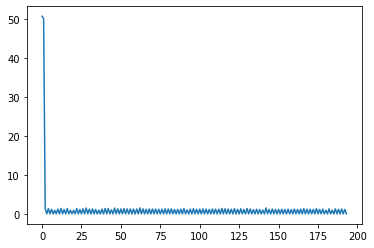

In [66]:
pred_wavelet = model.predict(X_test)
p = pred_wavelet
pp = [arr[0][0]]
pp2 = [arr[0][1]]
for i in range(1,len(p),2):
    pp.append(p[i][0])
    pp2.append(p[i][1])
rev = pywt.idwt(pp,pp2, 'db1')
plt.plot(rev)

In [68]:


# Custom Activation function Layer
import tensorflow_wavelets.Layers.Threshold as Threshold
dataset = keras.utils.timeseries_dataset_from_array(
    data=elecs_norm['e_price'].iloc[:-1],
    targets=elecs_norm['e_price'].iloc[28:],
    sequence_length=28,
    batch_size=1,
)
import tensorflow_datasets as tfds
tfex = (tfds.as_numpy(
dataset))
#print(tfex.shape)
array = []
targets = []
for ex,tag in tfex:
      array.append(ex)
      targets.append(tag)
array = np.array(array)
targets = np.array(targets)
print(array.shape)
array = np.expand_dims(array,axis=-1)
targets= np.expand_dims(targets,axis=-1)
from tensorflow import keras

model = keras.Sequential()
model.add(keras.Input(shape=(1,28, 1)))
model.add(DWT.DWT(name="gaus",concat=0))
model.add(ConvLSTM1D(
filters=128,
kernel_size=3,
#batch_input_shape=(None, 2, 28, 1),
#input_shape=(None,2, 28, 1),
padding="same",
return_sequences=True,
data_format="channels_last",
    activation="relu"
))
model.add(ConvLSTM1D(
filters=128,
kernel_size=3,
#batch_input_shape=(None, 2, 28, 1),
#input_shape=(None,2, 28, 1),
padding="same",
return_sequences=True,
data_format="channels_last",
    activation="relu"
))
model.add(ConvLSTM1D(
filters=128,
kernel_size=3,
#batch_input_shape=(None, 2, 28, 1),
#input_shape=(None,2, 28, 1),
padding="same",
return_sequences=True,
data_format="channels_last",
    activation="relu"
))
model.add(keras.layers.Flatten())
#model.add(LSTM(20))
model.add(keras.layers.Dense(1, activation="relu"))
model.summary()
model.compile(optimizer='adam',loss='mse')
#model.summary()
model.fit(array[:trainset_size],targets[:trainset_size], epochs=15)

(612, 1, 28)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaus (DWT)                  (None, 1, 14, 4)          0         
                                                                 
 conv_lstm1d (ConvLSTM1D)    (None, 1, 14, 128)        203264    
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 1, 14, 128)        393728    
                                                                 
 conv_lstm1d_2 (ConvLSTM1D)  (None, 1, 14, 128)        393728    
                                                                 
 flatten (Flatten)           (None, 1792)              0         
                                                                 
 dense_10 (Dense)            (None, 1)                 1793      
                                                                 
Total params: 992,513
Trainable params: 9

-2055.216991807978

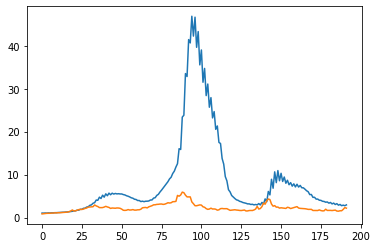

In [74]:
pred = (model.predict(array))
plt.plot(pred[trainset_size-28:])
plt.plot(elecs_norm[trainset_size:].values)
calc_r2(pd.Series(pred.ravel()[trainset_size-28:]),elecs_norm[trainset_size-1:],0)

In [138]:
pred.ravel()[trainset_size:].size

356

In [139]:
elecs_norm[trainset_size:].size

384

In [9]:
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Permute, Lambda
from keras.layers import TimeDistributed
import tensorflow as tf
from keras import Input
from keras.layers import GRU

from keras.layers.convolutional import Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D, UpSampling1D, UpSampling2D, ZeroPadding1D
# from keras.layers.advanced_activations import ParametricSoftplus, SReLU
from keras.callbacks import ModelCheckpoint, Callback
def ufcnn_model_concat(sequence_length=5000,
                       features=1,
                       nb_filter=150,
                       filter_length=5,
                       output_dim=1,
                       optimizer='adagrad',
                       loss='mse',
                       regression = True,
                       class_mode=None,
                       activation="relu",
                       init="lecun_uniform",
                       wavelet = False):
    #model = tf.keras.Sequential()

    #########################################################
    #x = ZeroPadding1D(2, name='input_padding') (inputs)# to avoid lookahead bias
    inputs = (keras.Input(shape=(1,sequence_length, features)))
    inputs = DWT.DWT(name="db6",concat=0)(inputs)
    inputs = tf.expand_dims(tf.reshape(inputs,shape=(-1,sequence_length*features)), axis=-1)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='valid', kernel_initializer=init, input_shape=(1,sequence_length, features),name='conv1')(inputs)
    start = Activation(activation, name='relu1')(x)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv2')(start)
    start2 = Activation(activation, name='relu2')(x)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv3')(start2)
    x = Activation(activation, name='relu3')(x)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv4')(x)
    x = Activation(activation, name='relu4')(x)
    #########################################################
    x = tf.keras.layers.concatenate([start2, x], axis=-1)
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv5')(x)
    x = Activation(activation, name='relu5')(x)
    #########################################################

    #########################################################
    x = tf.keras.layers.concatenate([start, x], axis=-1)
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv6')(x)
    x = Activation(activation, name='relu6')(x)
    #########################################################
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv7')(x)
    x = GRU(128)(x)#keras.layers.Flatten()(x)
    #x = Convolution1D(filters=1, kernel_size=1, padding='same', kernel_initializer=init, name='conv8')(x)

    x = Activation('relu', name='relu7')(x)

    y = LSTM(128,return_sequences=True)(inputs)
    y = LSTM(64)(y)
    # y = Dense(1)(y)
    x = tf.keras.layers.concatenate([x, y], axis=-1)
    x = Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=optimizer, loss='mse')

    return model

In [45]:
window_size=10
#noisy_data = fn_addnoise(elecs_norm,trainset_size-valset_size)
log_data = np.log(elecs_norm+1)
batches=1
dataset = keras.utils.timeseries_dataset_from_array(
        data=log_data,
        targets=log_data[window_size:],
        sequence_length=window_size,
        batch_size=batches,
    )

# --- Define training, validation and testing datasets
# X_train = dataset.take(trainset_size-window_size)
# X_val =dataset.skip(trainset_size-valset_size-window_size).take(valset_size)
# X_test = dataset.skip(trainset_size-window_size).take(testset_size)
offset = 100
X_train = dataset.skip(offset).take(trainset_size-window_size-offset)
#X_val =dataset.skip(trainset_size-valset_size-window_size).take(valset_size)
X_test = dataset.skip(trainset_size-window_size).take(testset_size)
model = ufcnn_model_concat(10,1)
hist_wa = model.fit(X_train,epochs=15,validation_data=X_val, batch_size=batches, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])

Epoch 1/15
338/338 [==============================] - 13s 18ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 2/15
338/338 [==============================] - 5s 15ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 3/15
338/338 [==============================] - 5s 14ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 4/15
338/338 [==============================] - 5s 14ms/step - loss: 9.2852e-04 - val_loss: 9.1249e-04
Epoch 5/15
338/338 [==============================] - 4s 12ms/step - loss: 7.1261e-04 - val_loss: 8.2145e-04
Epoch 6/15
338/338 [==============================] - 4s 11ms/step - loss: 6.3302e-04 - val_loss: 7.7242e-04
Epoch 7/15
338/338 [==============================] - 4s 12ms/step - loss: 6.0283e-04 - val_loss: 7.4403e-04
Epoch 8/15
338/338 [==============================] - 4s 12ms/step - loss: 5.8735e-04 - val_loss: 7.2795e-04
Epoch 9/15
338/338 [==============================] - 4s 10ms/step - loss: 5.7884e-04 - val_loss: 7.1934e-04
Epoch 10/15
338/338 [=====================

-7.715862015302239

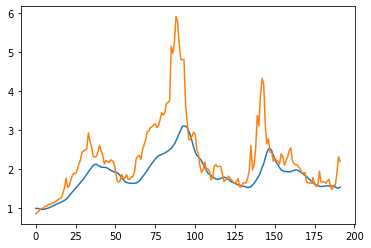

In [46]:
f = np.exp(model.predict(X_test.take(testset_size)))-1

plt.plot(f)
plt.plot(elecs_norm[trainset_size:].values)
calc_r2(pd.Series(f.ravel()),elecs_norm[trainset_size-1:],0)

In [ ]:
for i in range(10):

In [ ]:
def calc_r22(prediction,real,obs_size):
    """
    :param prediction: The forecasted time series
    :param real: The expected time series composed of real observations
    :param obs_size: The window size of
    :return: floating point r2 score <=1
    """
    lstm_diff = prediction.iloc[1:].values.reshape(-1,1) - prediction.iloc[:-1].values.reshape(-1,1)
    temp_diff = real.iloc[1:].values.reshape(-1,1) - real.iloc[:-1].values.reshape(-1,1)
    return sklearn.metrics.r2_score(temp_diff.reshape(-1,1), lstm_diff.reshape(-1,1))

In [49]:
def calc_r2(prediction,real,obs_size):
    """
    :param prediction: The forecasted time series
    :param real: The expected time series composed of real observations
    :param obs_size: The window size of
    :return: floating point r2 score <=1
    """
    lstm_diff = prediction.values.reshape(-1,1) - real.iloc[:-1].values.reshape(-1,1)
    #mask = np.all(np.isnan(lstm_diff),axis=1)
    #lstm_diff = lstm_diff[~mask].reshape(-1,1)
    temp_diff = real.iloc[1:].values.reshape(-1,1) - real.iloc[:-1].values.reshape(-1,1)
    #mask = np.all(np.isnan(temp_diff),axis=1)
    #temp_diff = temp_diff[~mask].reshape(-1,1)
    return sklearn.metrics.r2_score(temp_diff.reshape(-1,1), lstm_diff.reshape(-1,1))

-7.715862015302239

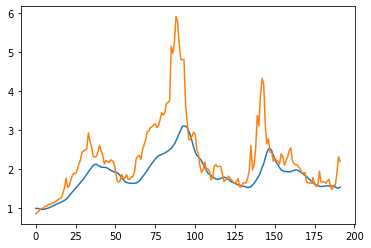

In [48]:
f = np.exp(model.predict(X_test.take(testset_size)))-1

plt.plot(f)
plt.plot(elecs_norm[trainset_size:].values)
calc_r2(pd.Series(f.ravel()),elecs_norm[trainset_size-1:],0)

so do a loop like refitting arima and take from dataset an adequate amount of data to fit model for 1 day ahead.

In [21]:
window_size=5
price_change = elecs_norm.diff(1).dropna() > 0
price_change['e_price'] = price_change['e_price'].astype(int)

dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=price_change[window_size:],
        sequence_length=window_size,
        batch_size=1,
)
X_train = dataset.take(trainset_size-window_size)
X_test = dataset.skip(trainset_size-window_size)

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
hist = model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])

Epoch 1/15
443/443 [==============================] - 5s 5ms/step - loss: 18.1576 - accuracy: 0.5350 - precision: 0.5156 - recall: 0.4670 - val_loss: 0.6747 - val_accuracy: 0.6021 - val_precision: 0.5847 - val_recall: 1.0000
Epoch 2/15
443/443 [==============================] - 2s 4ms/step - loss: 0.6974 - accuracy: 0.5192 - precision: 0.4963 - recall: 0.3160 - val_loss: 0.6746 - val_accuracy: 0.6021 - val_precision: 0.5847 - val_recall: 1.0000
Epoch 3/15
443/443 [==============================] - 2s 4ms/step - loss: 0.6972 - accuracy: 0.5214 - precision: 0.5000 - recall: 0.3160 - val_loss: 0.6746 - val_accuracy: 0.6021 - val_precision: 0.5847 - val_recall: 1.0000
Epoch 4/15
443/443 [==============================] - 2s 4ms/step - loss: 0.6972 - accuracy: 0.5214 - precision: 0.5000 - recall: 0.3160 - val_loss: 0.6746 - val_accuracy: 0.6021 - val_precision: 0.5847 - val_recall: 1.0000
Epoch 5/15
443/443 [==============================] - 2s 4ms/step - loss: 0.6972 - accuracy: 0.5214 - p

In [125]:
from ufcnn import ufcnn_model
model = ufcnn_model(10,1)
hist = model.fit(X_train,epochs=15,validation_data=X_test, batch_size=1, verbose=1, shuffle=False)#, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])


Epoch 1/15
1727/1727 [==============================] - 6s 3ms/step - loss: 8.4204e-04 - val_loss: 1.3200
Epoch 2/15
1727/1727 [==============================] - 4s 2ms/step - loss: 0.0022 - val_loss: 1.7170
Epoch 3/15
1727/1727 [==============================] - 4s 2ms/step - loss: 0.0029 - val_loss: 1.3255
Epoch 4/15
1727/1727 [==============================] - 4s 2ms/step - loss: 0.0031 - val_loss: 1.3385
Epoch 5/15
1727/1727 [==============================] - 5s 3ms/step - loss: 0.0045 - val_loss: 3.1727
Epoch 6/15
1727/1727 [==============================] - 5s 3ms/step - loss: 0.0038 - val_loss: 2.2068
Epoch 7/15
1727/1727 [==============================] - 4s 3ms/step - loss: 0.0040 - val_loss: 2.4600
Epoch 8/15
1727/1727 [==============================] - 5s 3ms/step - loss: 0.0046 - val_loss: 2.2782
Epoch 9/15
1727/1727 [==============================] - 4s 3ms/step - loss: 0.0051 - val_loss: 2.3315
Epoch 10/15
1727/1727 [==============================] - 5s 3ms/step - loss: 0

Transfer learning

In [11]:
window_size=10
offset=11
dataset = keras.utils.timeseries_dataset_from_array(
        data=elecs_norm[:-1],
        targets=elecs_norm[window_size:],
        sequence_length=window_size,
        batch_size = 1
)
X_train = dataset.take(trainset_size-window_size)
X_test = dataset.skip(trainset_size-window_size).take(testset_size)

In [ ]:
m  = keras.Sequential()
m.add(LSTM(64, activation='relu', input_shape=(10, 1),return_sequences=True,name='tran_lstm'))
m.add(tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None))
m.add(LSTM(64, activation='relu',return_sequences=False,name='lstm2'))
m.add(tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None))
m.add(Dense(1))
m.compile(optimizer='adam', loss='mse', metrics=['mape', 'mae'])
m.summary()
m.compile(optimizer='adam', loss='mse', metrics=['mae','mape'], run_eagerly=True)
m.fit(X_train,epochs=15,validation_data=X_test, verbose=1, shuffle=False)
t_pred = m.predict(X_test)
calc_metrics(denorm(t_pred),real =dfe['e_price'].values[trainset_size:])
m.trainable=False

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tran_lstm (LSTM)            (None, 10, 64)            16896     
                                                                 
 dropout_2 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm2 (LSTM)                (None, 64)                33024     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1727/1727 [============================

In [65]:
ma = make_single_lstm(64,10, 0.5)
ma.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_162 (Dense)           (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [54]:

inputs = tf.keras.Input(shape=(window_size, 1))
outputs = m(inputs)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = tf.keras.layers.Dense(1)(x)
tran_model = tf.keras.Model(inputs, outputs)
tran_model.compile(optimizer='adam', loss='mse', metrics=['mape', 'mae'])
# tran_model.fit(X_train,epochs=2,validation_data=X_test, batch_size=1, verbose=1, shuffle=False)
# tran_pred = tran_model.predict(X_test)
# calc_metrics(denorm(tran_pred),real =dfe['e_price'].values[trainset_size:])

ValueError: Exception encountered when calling layer "dropout_18" (type Dropout).

Attempt to convert a value (<keras.layers.rnn.lstm.LSTM object at 0x7fbf4c650850>) with an unsupported type (<class 'keras.layers.rnn.lstm.LSTM'>) to a Tensor.

Call arguments received by layer "dropout_18" (type Dropout):
  • inputs=<keras.layers.rnn.lstm.LSTM object at 0x7fbf4c650850>
  • training=False

In [51]:
tran_preds = []
train_num=50

aux_model = tf.keras.Model(inputs=m.inputs,
                           outputs= m.layers[0].output)
aux_model.trainable=False
input = Input(window_size,1)
x = aux_model(input)
x = LSTM(64,activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = Dense(1)
for i in range(testset_size):
    train = dataset.skip(trainset_size-window_size-train_num+i).take(train_num)
    test = dataset.skip(trainset_size-window_size+i).take(1)
    inputs = tf.keras.Input(shape=(window_size, 1))
    x = aux_model(inputs)
    #x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    tran_model = tf.keras.Model(inputs, outputs)
    tran_model.compile(optimizer='adam', loss='mse', metrics=['mape', 'mae'])
    tran_model.fit(train,epochs=2,validation_data=X_test, batch_size=1, verbose=1, shuffle=False)
    tran_preds.append(tran_model.predict(test))

Epoch 1/2
50/50 [==============================] - 3s 19ms/step - loss: 6.1759 - mape: 272.3978 - mae: 2.3585 - val_loss: 308.1385 - val_mape: 637.4054 - val_mae: 14.3145
Epoch 2/2
1/1 [==============================] - 0s 308ms/step
Epoch 1/2
50/50 [==============================] - 2s 17ms/step - loss: 13.1268 - mape: 364.0567 - mae: 3.1951 - val_loss: 2081.2825 - val_mape: 1548.0962 - val_mae: 35.0329
Epoch 2/2
1/1 [==============================] - 0s 308ms/step
Epoch 1/2
50/50 [==============================] - 2s 15ms/step - loss: 54.4256 - mape: 737.3870 - mae: 6.6407 - val_loss: 4938.6772 - val_mape: 2466.1614 - val_mae: 55.5930
Epoch 2/2
1/1 [==============================] - 0s 293ms/step
Epoch 1/2
50/50 [==============================] - 2s 14ms/step - loss: 7.9958 - mape: 276.4251 - mae: 2.5865 - val_loss: 400.5104 - val_mape: 722.7986 - val_mae: 16.2422
Epoch 2/2
1/1 [==============================] - 0s 296ms/step
Epoch 1/2
50/50 [==============================] - 2s 15ms

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [52]:
len(tran_preds)

140

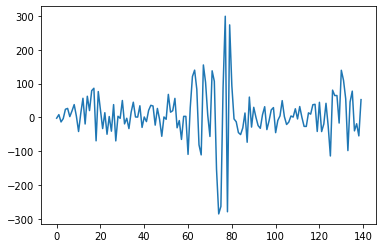

In [53]:
plt.plot(np.array(tran_preds).ravel())